In [16]:
%load_ext autoreload
%autoreload
import ipywidgets as w
import os
import random
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import sys
import traitlets
from IPython.display import clear_output
from passport_mrz_reader.common.interfaces import PreProcessors, PostProcessors
from passport_mrz_reader.common.mrz_common import display_if_verbose
from passport_mrz_reader.common.preprocessing import preprocess
from passport_mrz_reader.common.postprocessing import postprocess
from passport_mrz_reader.common.engines import Tesseract, EasyOcr, DeepLearning
from passport_mrz_reader.common.process import process
from passport_mrz_reader.utils.custom_passport_checker import CustomPassportChecker
from passport_mrz_reader.test_suite.test import check_recognition, accumulate
import multiprocessing as mp
from functools import reduce


# Load images
base_image_path = "../../data/images/PRADO MRZ/"
data = pd.read_csv('../../data/labeled passport data.csv', index_col=0)
image_names: list[str] = [image_name for image_name in data.index]
image_file_paths = [os.path.join(base_image_path, image_name) for image_name in image_names]
images = [np.asarray(np.asarray(Image.open(file_name))) for file_name in image_file_paths]
correct_texts = ["\n".join((data.loc[image_name, "Linje 1"], data.loc[image_name, "Linje 2"])) for image_name in image_names]

# Plan UI
skip_preprocessing_toggle = w.Checkbox(value=False, description="Skip preprocessing")
pre_processors = w.SelectMultiple(options=["grayscale", "threshold", "variable_threshold"], value=["grayscale", "threshold", "variable_threshold"], description="Pre-processing")
traitlets.link((skip_preprocessing_toggle, 'value'), (pre_processors, 'disabled'))
engine_select = w.Select(options=["Tesseract", "Deep Learning", "EasyOcr"], value="Tesseract", description="Engine")
skip_postprocessing_toggle = w.Checkbox(value=False, description="Skip postprocessing")
post_processors = w.SelectMultiple(options=["character_height", "line_lengths", "mrz_fields"], value=["character_height", "line_lengths", "mrz_fields"], description="Post-processing")
traitlets.link((skip_postprocessing_toggle, 'value'), (post_processors, 'disabled'))

# General settings settings
do_multiprocessing_toggle = w.Checkbox(value=True, description="Use multiprocessing")
processes = w.IntSlider(value=os.cpu_count(), min=2, max=os.cpu_count(), step=1, description="Processes:")
traitlets.link((do_multiprocessing_toggle, 'value'), (processes, 'disabled'), [lambda value: not value, None])
multiprocessing_settings = w.VBox([do_multiprocessing_toggle, processes])
do_report_toggle = w.Checkbox(value=True, description="Write report to file")


plan_title = w.HTML(value="<h1>Plan</h1>")
settings_title = w.HTML(value="<h1>Settings</h1>")

apply_plan_button = w.Button(description="Apply plan", icon="save")
apply_plan_button.on_click(lambda _: apply_plan())

def apply_plan():
    global apply_button, settings

    def apply_settings():
        global pre_options, engine, post_options, num_processes, should_write_report
        pre_options = PreProcessors(
            grayscale=True if "grayscale" in pre_processors.value else None,
            threshold=threshold_slider.value if "threshold" in pre_processors.value else None,
            variable_threshold=True if "variable_threshold" in pre_processors.value else None,
        ) if not skip_preprocessing_toggle.value else PreProcessors()

        post_options = PostProcessors(
            character_height=True if "character_height" in post_processors.value else None,
            mrz_fields=True if "mrz_fields" in post_processors.value else None,
            line_lengths=True if "line_lengths" in post_processors.value else None
        ) if not skip_postprocessing_toggle.value else PostProcessors()

        if engine_select.value == "Tesseract":
            engine = Tesseract(dict())
        elif engine_select.value == "EasyOcr":
            engine = EasyOcr(dict())
        elif engine_select.value == "Deep Learning":
            engine = DeepLearning(dict())
        else:
            raise NotImplementedError
        
        num_processes = processes.value if do_multiprocessing_toggle.value else 1
        should_write_report = do_report_toggle.value


    # Settings UI
    children = []
    if not skip_preprocessing_toggle.value:
        if "threshold" in pre_processors.value:
            threshold_slider = w.IntSlider(value=10, min=0, max=100, step=1, description="threshold:")
            children.append(("threshold", threshold_slider))

    if not skip_postprocessing_toggle.value:
        pass

    children.append(("Multiprocessing", multiprocessing_settings))
    children.append(("Reporting", do_report_toggle))
    
    settings = w.Accordion(children=list(map(lambda c: c[1], children)))
    for i, child in enumerate(children):
        settings.set_title(i, child[0])
    apply_button = w.Button(description="Apply settings", icon="save")
    apply_button.on_click(lambda _: apply_settings())

    apply_settings()
    clear_output()
    display(w.VBox([skip_preprocessing_toggle, pre_processors, engine_select, skip_postprocessing_toggle, post_processors, apply_plan_button, settings, apply_button]))

apply_plan()

Processing image 25899.jpeg


'Original image'

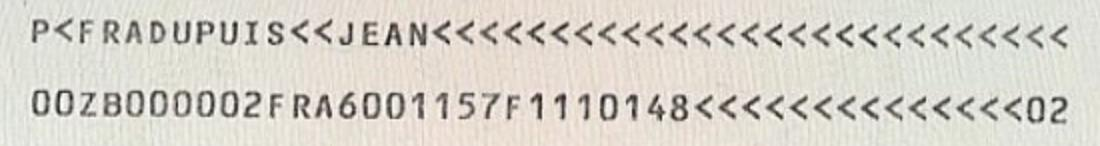

Only using variable threshold, disregarding threshold and grayscale


'After resizing'

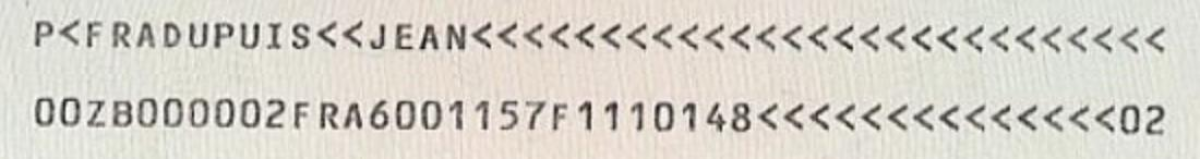

'After grayscaling'

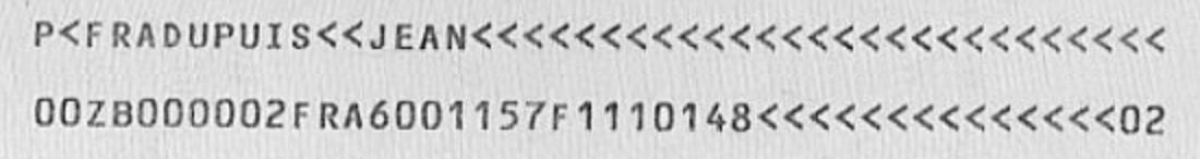

'After thresholding with threshold 10'

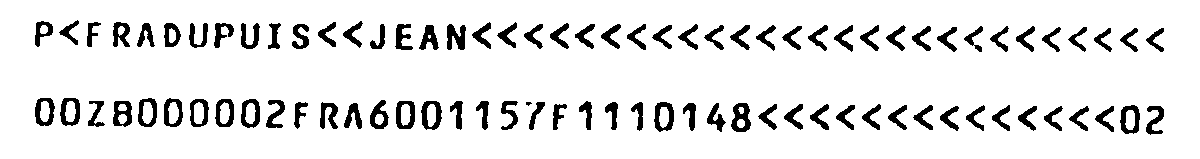

'After un-grayscaling'

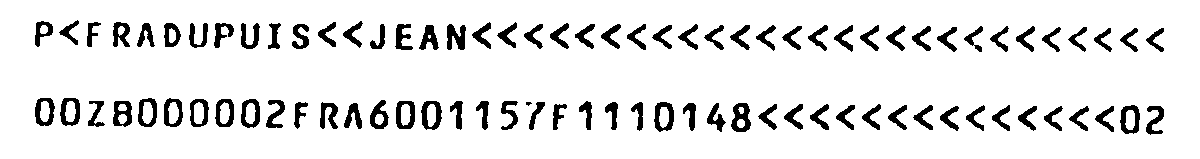

'Inverted MRZ region'

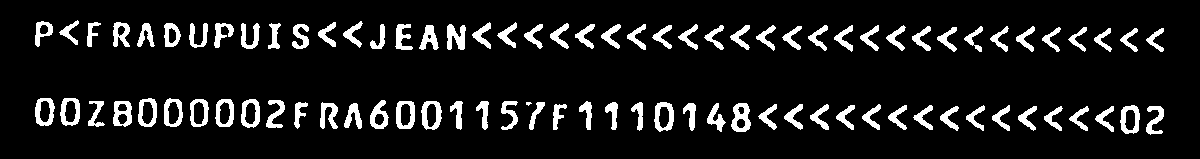

'Original bounding boxes'

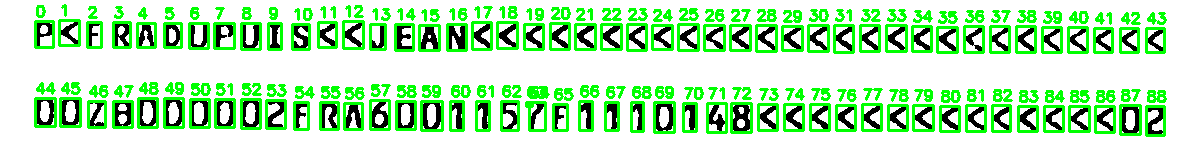

'After dropping small and large boxes'

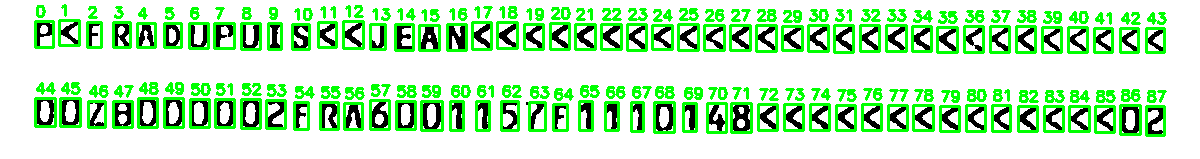

Found 88 bounding boxes
3/3 [==============================] - 0s 136ms/step
MRZ text before postprocessing:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA600115FF1110148<<<<<<<<<<<<<<02
MRZ text after looking at box heights:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA600115FF1110148<<<<<<<<<<<<<<02
MRZ text after looking at line lengths:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA600115FF1110148<<<<<<<<<<<<<<02
MRZ text after looking at MRZ fields:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA600115FF1110148<<<<<<<<<<<<<<02

Final result:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA600115FF1110148<<<<<<<<<<<<<<02
Valid: False
Wrong format for second line
Correct: False
Should be:
P<FRADUPUIS<<JEAN<<<<<<<<<<<<<<<<<<<<<<<<<<<
00ZB000002FRA6001157F1110148<<<<<<<<<<<<<<02


In [15]:
%autoreload
# Process single image
index = 0
image = images[index]
image_name = image_names[index]
print(f"Processing image {image_name}")
result = process(image, pre_options, engine, post_options, verbose=True)
correct = result == correct_texts[index]
if result is not None:
    lines = result.split("\n")
    checker = CustomPassportChecker(lines[0], lines[1])
    valid = checker.is_correct()
else:
    valid = False

print("\nFinal result:")
print(f"{result}")
print(f"Valid: {valid}")
if result is not None and not valid:
    print("\n".join(checker.get_reasons_failing()))
print(f"Correct: {correct}")
if not correct:
    print("Should be:\n" + correct_texts[index])

In [19]:
%autoreload
configs = ((pre_options, engine, post_options) for _ in images)
ids = iter(image_names)
workloads = zip(images, correct_texts, configs, ids)

print(
    "Using configuration",
    (pre_options, engine, post_options),
    f"with {num_processes} process{'es' if num_processes > 1 else ''}",
    f"and with{'' if should_write_report else 'out'} final report",
)
with mp.Pool(num_processes) as pool:
    results_generator = pool.imap_unordered(check_recognition, workloads)
    summary = reduce(accumulate, results_generator, ([], 0, 0, 0, len(images)))
print("✔")

if should_write_report:
    with open("report.tsv", "w", encoding="utf8") as file:
        file.write("Filename\tIndex\tValid\tCorrect\tRead1\tRead2\tLabeled1\tLabeled2\tReasonsForInvalidity\n")
        for item in sorted(summary[0], key=lambda item: item[0]):
            id, valid, correct, read_text, labeled_text, reasons = item
            read_text = read_text.replace("\n", "\t") if read_text is not None else "\t"
            labeled_text = labeled_text.replace("\n", "\t")
            num = image_names.index(id)
            reasons_formatted = '; '.join(reasons) if reasons is not None else ''
            file.write(f"{id}\t{num}\t{valid}\t{correct}\t{read_text}\t{labeled_text}\t{reasons_formatted}\n")

Using configuration (PreProcessors(grayscale=True, threshold=10, variable_threshold=True), <passport_mrz_reader.common.engines.DeepLearning object at 0x0000023C3BBD3B80>, PostProcessors(character_height=True, mrz_fields=True, line_lengths=True)) with 1 process and with final report
✔ Processed: 2/2 (100%)    Valid: 1/2 (50%)    Correct: 1/2 (50%)    
